In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad, odeint
import matplotlib.pyplot as plt

In [2]:
P_int      =interp1d(np.loadtxt("QED/QED_P_int.cvs")[:,0],np.loadtxt("QED/QED_P_int.cvs")[:,1]+np.loadtxt("QED/QED_P_int.cvs")[:,2],bounds_error=False,fill_value=0.0,kind='linear')
dP_intdT   =interp1d(np.loadtxt("QED/QED_dP_intdT.cvs")[:,0],np.loadtxt("QED/QED_dP_intdT.cvs")[:,1]+np.loadtxt("QED/QED_dP_intdT.cvs")[:,2],bounds_error=False,fill_value=0.0,kind='linear')
d2P_intdT2 =interp1d(np.loadtxt("QED/QED_d2P_intdT2.cvs")[:,0],np.loadtxt("QED/QED_d2P_intdT2.cvs")[:,1]+np.loadtxt("QED/QED_d2P_intdT2.cvs")[:,2],bounds_error=False,fill_value=0.0,kind='linear')

In [3]:
# All in MeV Units!
GF  = 1.1663787e-5*1e-6 #in MeV^{-2}
me  = 0.511
Mpl = 1.22091e19*1e3

# Conversion factor to convert MeV^-1 into seconds
FAC = 1./(6.58212e-22)

# Left and Right nu-e couplings as relevant for E < 10 MeV. From the EW review of the PDG
geL, geR, gmuL, gmuR = 0.727, 0.233, -0.273, 0.233
# 

In [4]:
# Thermodynamics of Standard and New Species

def rho_nu(T):  return 2 * 7./8. * np.pi**2/30. * T**4

def rho_gam(T): return 2 * np.pi**2/30. * T**4

def rho_phi(T): return np.pi**2/30. * T**4

def rho_e(T):
    if T < me/30.0:        return 0.0
    else:        return 4./(2*np.pi**2)*T**4*quad(lambda E: E**2*(E**2-(me/T)**2)**0.5/(np.exp(E)+1.) ,me/T,100,epsabs=1e-12,epsrel = 1e-12)[0]

def p_e(T):
    if T < me/30.0:        return 0.0
    else:        return 4./(6*np.pi**2)*T**4*quad(lambda E: (E**2-(me/T)**2)**1.5/(np.exp(E)+1.) ,me/T,100,epsabs=1e-12,epsrel = 1e-12)[0]

# Derivatives
def drho_nudT(T):     return 4*rho_nu(T)/T

def drho_gamdT(T):    return 4*rho_gam(T)/T

def drho_phidT(T):    return 4*rho_phi(T)/T

def drho_edT(T):
    if T < me/30.0:  return 0.0
    else:        return 4./(2*np.pi**2)*T**3*quad(lambda E: 0.25*E**3*(E**2-(me/T)**2)**0.5*np.cosh(E/2.0)**-2 ,me/T,100,epsabs=1e-12,epsrel = 1e-12)[0]

# Rho tot
def rho_tot(T_gam, T_nue, T_numu, T_phi):
    return rho_gam(T_gam) + rho_e(T_gam) + rho_phi(T_phi) + rho_nu(T_nue) + 2*rho_nu(T_numu) - P_int(T_gam) + T_gam*dP_intdT(T_gam)

# P tot
def p_tot(T_gam, T_nue, T_numu):
    return  1./3. * rho_gam(T_gam) + p_e(T_gam) + 1./3. * rho_nu(T_nue) + 1./3. * 2*rho_nu(T_numu) + P_int(T_gam)

# Hubble
def Hubble(T_gam, T_nue, T_numu, T_phi):
    return FAC * (rho_tot(T_gam, T_nue, T_numu, T_phi)*8*np.pi/(3*Mpl**2))**0.5

# Neff Definition
def Neff_func(T_gam, T_nue, T_numu, T_phi):
    return 8./7.*(11./4.)**(4./3.)*(rho_nu(T_nue) + 2*rho_nu(T_numu) + rho_phi(T_phi)) / rho_gam(T_gam)


# Suppression of the rates as a result of a non-negligible electron mass
f_nue_s  = interp1d(np.loadtxt("SM_Rates/nue_scatt.dat")[:,0],np.loadtxt("SM_Rates/nue_scatt.dat")[:,1],kind='linear')
f_numu_s = interp1d(np.loadtxt("SM_Rates/numu_scatt.dat")[:,0],np.loadtxt("SM_Rates/numu_scatt.dat")[:,1],kind='linear')
f_nue_a  = interp1d(np.loadtxt("SM_Rates/nue_ann.dat")[:,0],np.loadtxt("SM_Rates/nue_ann.dat")[:,1],kind='linear')
f_numu_a = interp1d(np.loadtxt("SM_Rates/numu_ann.dat")[:,0],np.loadtxt("SM_Rates/numu_ann.dat")[:,1],kind='linear')

##Uncomment in order to remove the effect of m_e in the rates.
##f_nue_s, f_numu_s, f_nue_a, f_numu_a   = lambda T : 1, lambda T : 1, lambda T : 1, lambda T : 1

def Ffunc_nue_e(T1,T2):
    return 32* 0.884 *(T1**9 - T2**9) * f_nue_a(T1)  + 56 * 0.829 * f_nue_s(T1)  *T1**4*T2**4*(T1-T2)
def Ffunc_numu_e(T1,T2):
    return 32* 0.884 *(T1**9 - T2**9) * f_numu_a(T1) + 56 * 0.829 * f_numu_s(T1) *T1**4*T2**4*(T1-T2)
def Ffunc(T1,T2):
    return 32* 0.884 *(T1**9 - T2**9) + 56* 0.829 *T1**4*T2**4*(T1-T2)

# Energy Transfer Rates
def DeltaRho_nue(T_gam,T_nue,T_numu):
    return FAC * GF**2/np.pi**5 * ( 4* (geL**2 + geR**2) * Ffunc_nue_e(T_gam,T_nue)  + 2*Ffunc(T_numu,T_nue) )
def DeltaRho_numu(T_gam,T_nue,T_numu):
    return FAC * GF**2/np.pi**5 * ( 4* (gmuL**2 + gmuR**2) * Ffunc_numu_e(T_gam,T_numu) -   Ffunc(T_numu,T_nue) )

In [5]:
Mphi = 5.
#lam = 10**-6. #10**(-6)
mnu = 10**(-7) #0.1 ev

In [6]:
def DeltaRho_phi(T_nu, T_phi, lam):
    return (lam**4/np.pi**5)*( (T_nu**5)*np.log((2*T_nu)/mnu) - (T_phi**5)*np.log((2*T_phi)/mnu))   

def DeltaRho_nu(T_gam, T_nu):
    return DeltaRho_nue(T_gam, T_nu, T_nu) + 2*DeltaRho_numu(T_gam, T_nu, T_nu)

In [7]:
# Temperature Evolution Equations
def dTnu_dt(T_gam, T_nu, T_phi, lam):
    return - T_nu*Hubble(T_gam, T_nu, T_nu, T_phi) + (T_nu/(4*rho_nu(T_nu)))*( DeltaRho_nu(T_gam, T_nu) - DeltaRho_phi(T_nu, T_phi, lam) )

def dTgam_dt(T_gam, T_nu ,T_phi, lam):
    return -(Hubble(T_gam, T_nu, T_nu, T_phi)*(4*rho_gam(T_gam) + 3*(rho_e(T_gam) + p_e(T_gam)) + 3 * T_gam * dP_intdT(T_gam)) + DeltaRho_nu(T_gam, T_nu) )/( drho_gamdT(T_gam) + drho_edT(T_gam)  + T_gam * d2P_intdT2(T_gam) )

def dTphi_dt(T_gam, T_nu, T_phi, lam):
    return - T_phi*Hubble(T_gam, T_nu, T_nu, T_phi) + (T_phi/(4*rho_phi(T_phi)))*(DeltaRho_phi(T_nu, T_phi, lam)) 

def dT_totdt(vec, t, lam):
    T_gam, T_nu, T_phi = vec
    return [dTgam_dt(T_gam, T_nu,T_phi, lam), dTnu_dt(T_gam,T_nu,T_phi, lam),dTphi_dt(T_gam,T_nu,T_phi, lam)]

In [8]:
#Start the integration at a common temperature of 20 MeV, which corresponds to t ~ 2*10^{-3} s
T0 = 20.0
t0 = 1./(2*Hubble(T0,T0,T0,T0))

# Finish the calculation at t = 5*10^4 seconds, which will correspond to T ~ 5*10^{-3} MeV
t_max = 5e4

In [9]:
tvec = np.logspace(np.log10(t0), np.log10(t_max), num=300)

In [10]:
sola = odeint(dT_totdt, [T0,T0,T0/10], tvec, args=(0.1,), rtol = 1e-8, atol= 1e-8)
solb = odeint(dT_totdt, [T0,T0,T0/10], tvec, args=(1.,), rtol = 1e-8, atol= 1e-8)
solc = odeint(dT_totdt, [T0,T0,T0/10], tvec, args=(10,), rtol = 1e-8, atol= 1e-8)

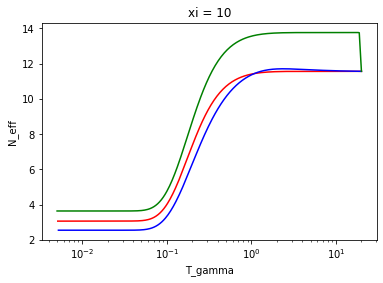

In [44]:
plt.semilogx(sola[:,0], Neff_func(sola[:,0], sola[:,1], sola[:,1], sola[:,2]), 'r', label="r")
plt.semilogx(solb[:,0], Neff_func(solb[:,0], solb[:,1], solb[:,1], solb[:,2]), 'b')
plt.semilogx(solc[:,0], Neff_func(solc[:,0], solc[:,1], solc[:,1], solc[:,2]), 'g')
plt.xlabel("T_gamma");
plt.ylabel("N_eff");
plt.title("xi = 10");

In [12]:
sola2 = odeint(dT_totdt, [T0,T0,T0/100], tvec, args=(0.1,), rtol = 1e-8, atol= 1e-8)
solb2 = odeint(dT_totdt, [T0,T0,T0/100], tvec, args=(1.,), rtol = 1e-8, atol= 1e-8)
#solc = odeint(dT_totdt, [T0,T0,T0/100], tvec, args=(10,), rtol = 1e-8, atol= 1e-8)

In [57]:
sola3 = odeint(dT_totdt, [T0,T0,T0/1000], tvec, args=(0.1,), rtol = 1e-8, atol= 1e-8)
solb3 = odeint(dT_totdt, [T0,T0,T0/1000], tvec, args=(1.,), rtol = 1e-8, atol= 1e-8)
#solc3 = odeint(dT_totdt, [T0,T0,T0/1000], tvec, args=(10,), rtol = 1e-8, atol= 1e-8)

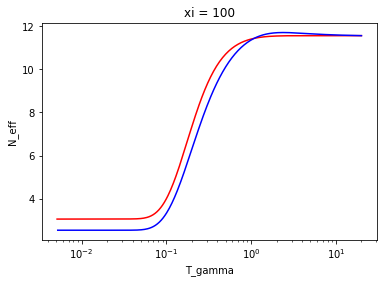

In [94]:
plt.semilogx(sola[:,0], Neff_func(sola2[:,0], sola2[:,1], sola2[:,1], sola2[:,2]), 'r')
plt.semilogx(solb[:,0], Neff_func(solb2[:,0], solb2[:,1], solb2[:,1], solb2[:,2]), 'b')
#plt.semilogx(solc[:,0], Neff_func(solc[:,0], solc[:,1], solc[:,1], solc[:,2]), 'g')
plt.xlabel("T_gamma");
plt.ylabel("N_eff");
plt.title("xi = 100");

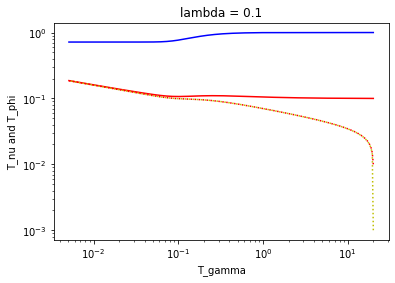

In [61]:
plt.loglog(sola[:,0], sola[:,1]/sola[:,0], 'b')
plt.loglog(sola[:,0], sola[:,2]/sola[:,0], 'r')
plt.loglog(sola2[:,0], sola2[:,2]/sola2[:,0], 'r:')
plt.loglog(sola3[:,0], sola3[:,2]/sola3[:,0], 'y:')
plt.xlabel("T_gamma");
plt.ylabel("T_nu and T_phi");
plt.title("lambda = 0.1");

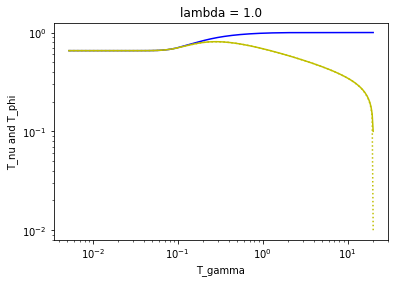

In [56]:
plt.loglog(solb[:,0], solb[:,1]/solb[:,0], 'b')
plt.loglog(solb[:,0], solb[:,2]/solb[:,0], 'y')
plt.loglog(solb2[:,0], solb2[:,2]/solb2[:,0], 'y:')
plt.xlabel("T_gamma");
plt.ylabel("T_nu and T_phi");
plt.title("lambda = 1.0");

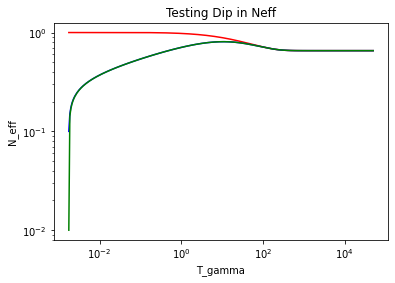

In [92]:
plt.loglog(tvec, solb[:,1]/solb[:,0], 'r')
plt.loglog(tvec, solb[:,2]/solb[:,0], 'b')
plt.loglog(tvec, solb2[:,2]/solb2[:,0], 'g')
#plt.loglog(tvec, solb2[:,1], 'b')
#plt.semilogx(solc[:,0], Neff_func(solc[:,0], solc[:,1], solc[:,1], solc[:,2]), 'g')
plt.xlabel("T_gamma");
plt.ylabel("N_eff");
plt.title("Testing Dip in Neff");

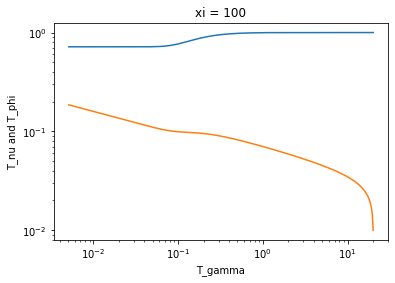

In [48]:
plt.loglog(sola2[:,0], sola2[:,1]/sola2[:,0])
plt.loglog(sola2[:,0], sola2[:,2]/sola2[:,0])
plt.xlabel("T_gamma");
plt.ylabel("T_nu and T_phi");
plt.title("xi = 100");

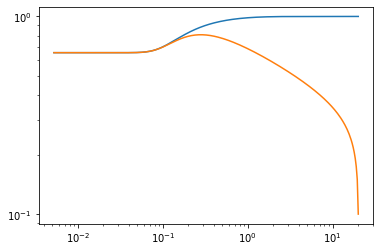

In [15]:
plt.loglog(solb[:,0], solb[:,1]/solb[:,0])
plt.loglog(solb[:,0], solb[:,2]/solb[:,0])

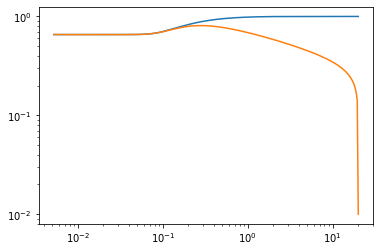

In [17]:
plt.loglog(solb2[:,0], solb2[:,1]/solb2[:,0])
plt.loglog(solb2[:,0], solb2[:,2]/solb2[:,0])

In [19]:
def myneff(ll):
    T0 = 20.0
    t0 = 1./(2*Hubble(T0,T0,T0,T0*ll/16))
    mysol = odeint(dT_totdt, [T0,T0,T0*ll/16], tvec, args=(ll*10**-6,), rtol = 1e-8, atol= 1e-8)
    return round(Neff_func(mysol[-1,0], mysol[-1,1], mysol[-1,1], mysol[-1,2]), 5)


In [20]:
def myneff_true(ll, xi):
    T0 = 20.0
    t0 = 1./(2*Hubble(T0,T0,T0,T0/xi))
    t_max = 5e4
    tvec = np.logspace(np.log10(t0), np.log10(t_max), num=300)
    mysol = odeint(dT_totdt, [T0,T0,T0/xi] , tvec, args=(ll,), rtol = 1e-8, atol= 1e-8)
    return [ round(Neff_func(mysol[-1,0], mysol[-1,1], mysol[-1,1], mysol[-1,2]), 5), round(Neff_func(mysol[-1,0], mysol[-1,1], mysol[-1,1], mysol[-1,1]), 5)]

In [29]:
len(neffdatt) 

45

In [21]:
%%time
myneff_true(1., 10)

CPU times: user 6.54 s, sys: 51 ms, total: 6.59 s
Wall time: 6.58 s


[2.54478, 2.54478]

In [175]:
%%time
myneff_true(.1, 10)

CPU times: user 5.84 s, sys: 26.6 ms, total: 5.86 s
Wall time: 5.85 s


[3.06009, 3.6398]

In [177]:
%%time
myneff_true(0.001, 10)

CPU times: user 5.82 s, sys: 39.2 ms, total: 5.85 s
Wall time: 5.85 s


[3.06527, 3.64907]

In [96]:
%%time
myneff(50.)

CPU times: user 5.66 s, sys: 32.8 ms, total: 5.7 s
Wall time: 5.69 s


57.82804

In [97]:
%%time
neffdatt = []
for n in np.arange(-2, 1.1, 0.1): 
    neffdatt.append(myneff_true(10**n, 10))

CPU times: user 3min 45s, sys: 1.05 s, total: 3min 46s
Wall time: 3min 46s


In [ ]:
%%time
neffdatt2 = []
for n in np.arange(-2, 1.1, 0.1): 
    neffdatt2.append(myneff_true(10**n, 100))

In [73]:
tp1 = []
tp2 = []
for i in range(len(neffdatt)):
    tp1.append(neffdatt[i][0])
    tp2.append(neffdatt[i][1])

In [74]:
tp3 = []
tp4 = []
for i in range(len(neffdatt2)):
    tp3.append(neffdatt2[i][0])
    tp4.append(neffdatt2[i][1])

ValueError: x and y must have same first dimension, but have shapes (31,) and (47,)

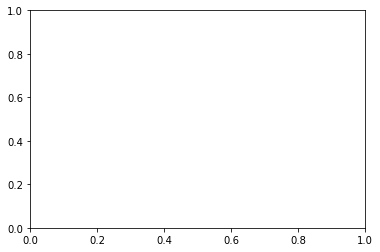

In [96]:
plt.plot(np.arange(-2, 1.1, 0.1), tp1)
plt.plot(np.arange(-2, 1.1, 0.1), tp2)
plt.xlabel("Log[lambda]");
plt.ylabel("N_eff");
plt.title("xi = 10");

ValueError: x and y must have same first dimension, but have shapes (31,) and (41,)

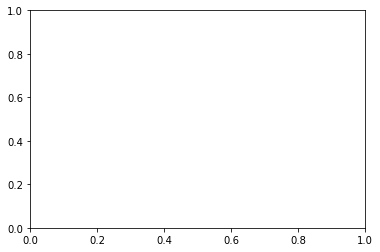

In [95]:
plt.plot(np.arange(-2, 1.1, 0.1), tp3)
plt.plot(np.arange(-2, 1.1, 0.1), tp4)
plt.xlabel("Log[lambda]");
plt.ylabel("N_eff");
plt.title("xi = 100");

In [97]:
%%time
neffdat = []
for n in range(1,101,10): 
    neffdat.append(myneff(n))

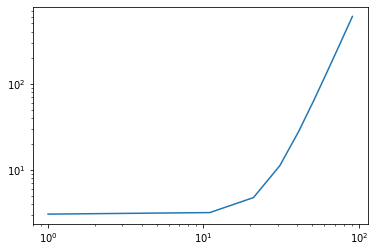

In [100]:
plt.loglog(range(1, 101,10), neffdat)

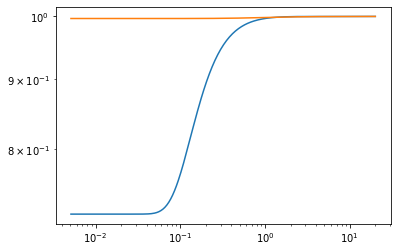

In [81]:
plt.loglog(sol[:,0], sol[:,1]/sol[:,0])
plt.loglog(sol[:,0], 3*sol[:,2]/sol[:,1])

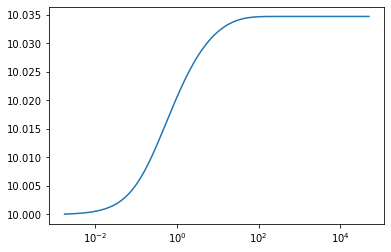

In [184]:
plt.plot(tvec, sol[:,1]/sol[:,2])
plt.xscale('log')

In [127]:
t0

0.001766198541123033

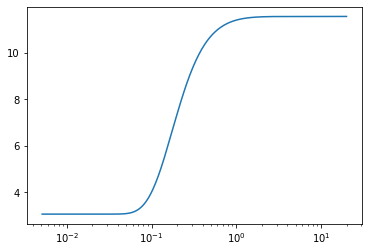

In [185]:
plt.semilogx(sol[:,0], Neff_func(sol[:,0], sol[:,1], sol[:,1], sol[:,2]))

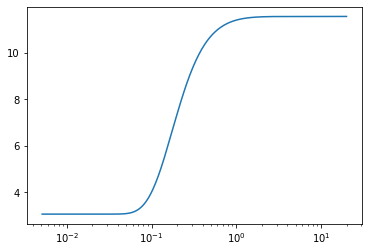

In [159]:
plt.semilogx( sol[:,0], Neff_func(sol[:,0], sol[:,1], sol[:,1], sol[:,2]))

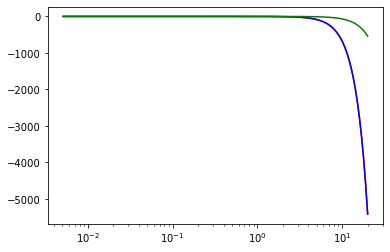

In [104]:
tgam = []
tnu = []
tphi = []

for i in range(len(tvec)):
    tnu.append(dTnu_dt(sol[i,0], sol[i,1], sol[i,2], 10**-6))

for i in range(len(tvec)):
    tgam.append(dTgam_dt(sol[i,0], sol[i,1], sol[i,2], 10**-6)) 

for i in range(len(tvec)):
    tphi.append(dTphi_dt(sol[i,0], sol[i,1], sol[i,2], 10**-6))
    
plt.semilogx( sol[:,0], tgam, 'r')
plt.semilogx( sol[:,0], tnu, 'b')
plt.semilogx( sol[:,0], tphi, 'g')

In [190]:
1./(2*Hubble(T0,T0,T0,T0))

0.001766198541123033

In [18]:
1./(2*Hubble(T0,T0,T0,T0/1000))

0.001846618850208736

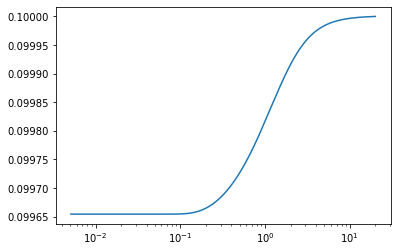

In [110]:
plt.semilogx(sol[:,0], sol[:,2]/sol[:,1])

In [112]:
1./(2*Hubble(1000,1000,1000,0))

7.381874753625998e-07

In [116]:
# New Temperature Evolution Equations
# Only in the early universe before neurtino-electron
def dTnu_dtt(T_nu, T_phi, lam):
    return - T_nu*Hubble(T_nu, T_nu, T_nu, T_phi) + (T_nu/(4*rho_nu(T_nu)))*(- DeltaRho_phi(T_nu, T_phi, lam) )

def dTphi_dtt(T_nu, T_phi, lam):
    return - T_phi*Hubble(T_nu, T_nu, T_nu, T_phi) + (T_phi/(4*rho_phi(T_phi)))*(DeltaRho_phi(T_nu, T_phi, lam)) 


def dT_totdtt(vec, t, lam):
    T_nu, T_phi = vec
    return [dTnu_dtt(T_nu,T_phi, lam), dTphi_dtt(T_nu,T_phi, lam)]

In [119]:
dT_totdtt([10, 0.1], 0.1, 0.1)

[-676.8979609846078, 467.8660953018908]

In [124]:
T0 = 5.0
t0 = 1./(2*Hubble(T0,T0,T0,T0))
print(t0)

0.02826208878996906


In [125]:
#Start the integration at a common temperature of 20 MeV, which corresponds to t ~ 2*10^{-3} s
T0 = 50.0
t0 = 1./(2*Hubble(T0,T0,T0,T0))

# Finish the calculation at t = 5*10^4 seconds, which will correspond to T ~ 5*10^{-3} MeV
t_max = 0.03

In [127]:
tvec = np.logspace(np.log10(t0), np.log10(t_max), num=300)

In [163]:
solt = odeint(dT_totdtt, [T0, T0/10], tvec, args=(1,), rtol = 1e-8, atol= 1e-8)

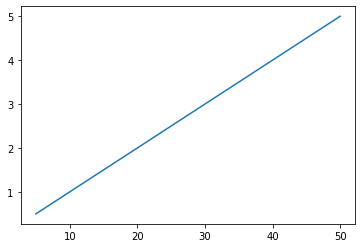

In [149]:
plt.plot(solt[:,0], solt[:,1])

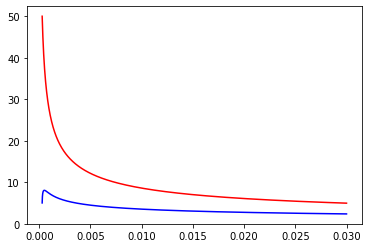

In [164]:
plt.plot(tvec, solt[:,0], 'r')
plt.plot(tvec, solt[:,1], 'b')

In [141]:
def numerator(T_nu, T_phi, lam):
    return T_nu*dTphi_dtt(T_nu,T_phi, lam) - T_phi*dTnu_dtt(T_nu,T_phi, lam)

In [147]:
numerator(10, .9, 10**-1)

6.510979661132751

In [228]:
sola = odeint(dT_totdt, [T0,T0,T0/10], tvec, args=(0.1,), rtol = 1e-8, atol= 1e-8)
solb = odeint(dT_totdt, [T0,T0,T0/10], tvec, args=(1.,), rtol = 1e-8, atol= 1e-8)
solc = odeint(dT_totdt, [T0,T0,T0/10], tvec, args=(10,), rtol = 1e-8, atol= 1e-8)

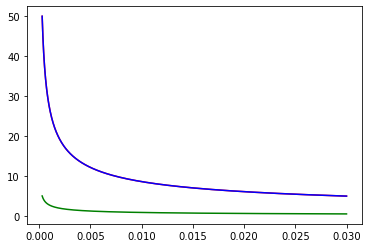

In [229]:
plt.plot(tvec, sola[:,0], 'r')
plt.plot(tvec, sola[:,1], 'b')
plt.plot(tvec, sola[:,2], 'g')

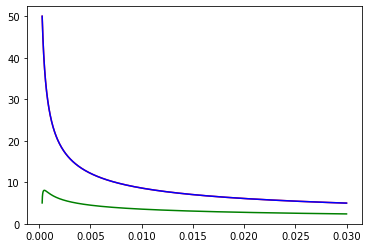

In [230]:
plt.plot(tvec, solb[:,0], 'r')
plt.plot(tvec, solb[:,1], 'b')
plt.plot(tvec, solb[:,2], 'g')

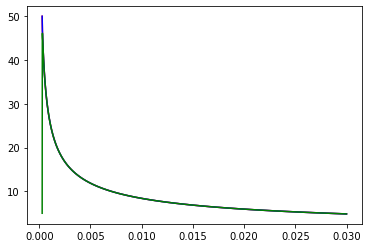

In [231]:
plt.plot(tvec, solc[:,0], 'r')
plt.plot(tvec, solc[:,1], 'b')
plt.plot(tvec, solc[:,2], 'g')

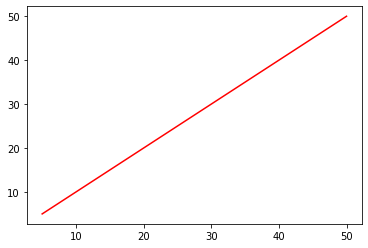

In [232]:
plt.plot(sola[:,0], sola[:,1], 'r')

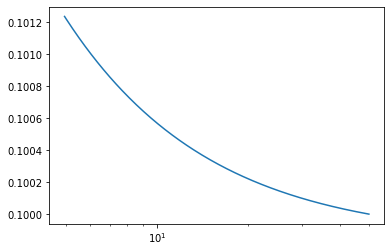

In [233]:
plt.semilogx(sola[:,0], sola[:,2]/sola[:,1])